In [1]:
import os
import yaml
from scipy.special import expit
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from regionmask import mask_geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams["font.family"] = ["serif", "sans-serif", "monospace"][0]

wd = "hazGAN2/projects/poweruk_winter"

ensemble_years = [15, 500][1]

with open(os.path.join(wd, "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)

regions = ["East Midlands", "West Midlands", "South West England", "South Wales"]
region_of_interest = regions[0]

season = config["sfunc"]
local_crs = config["local_crs"]

datasets = ["training", "generated"]

training = xr.open_dataset(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_training_{season}_{15}-ensembles.nc")
)

generated = xr.open_dataset(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_generated_{season}_{ensemble_years}-ensembles.nc")
)

gen_ensembles = generated.attrs["n_ensembles"]
ensemble_years = generated.attrs["ensemble_years"]
rp_max = generated.attrs["rp_max"]

ERROR 1: PROJ: proj_create_from_database: Open of /hn01-home/spet5107/micromamba/envs/hazGAN/share/proj failed


In [2]:
coef_path = os.path.join(wd, "resources", "E_Mid_All_Variable_Model_coefficients_wind-thresh=20.csv")
coefs = pd.read_csv(coef_path)
coefs.head()

,Variables,Coefficients,P_value
0,Intercept,-13.969870,1.330000e-13
1,Wind,0.432214,2.120000e-11
2,Rainfall,13.416561,3.991401e-02
3,Direction,0.014080,2.776643e-03
4,Spring,0.537586,3.116006e-01


## Marginal contribution to the probability

In [7]:
data = generated
norm = True

In [8]:
vx_clim  = data.vx.quantile(0.25, dim=["time"]).item()
dx_clim  = 0
r30_clim = data.r30.quantile(0.25, dim=["time"]).item()

ones = np.ones(data.vx.shape).reshape(-1, 1)
zeros = np.zeros(data.vx.shape).reshape(-1, 1)

X_full = np.hstack([
    ones,
    data.vx.values.reshape(-1, 1),
    data.r30.values.reshape(-1, 1),
    data.dx.values.reshape(-1, 1),
    zeros,
    zeros,
    zeros
    ])

X_vx = np.hstack([
    ones,
    vx_clim * np.ones(data.vx.shape).reshape(-1, 1),
    data.r30.values.reshape(-1, 1),
    data.dx.values.reshape(-1, 1),
    zeros,
    zeros,
    zeros
    ])

X_dx = np.hstack([
    ones,
    data.vx.values.reshape(-1, 1),
    data.r30.values.reshape(-1, 1),
    dx_clim * np.ones(data.vx.shape).reshape(-1, 1),
    zeros,
    zeros,
    zeros
    ])

X_r30 = np.hstack([
    ones,
    data.vx.values.reshape(-1, 1),
    r30_clim * np.ones(data.vx.shape).reshape(-1, 1),
    data.dx.values.reshape(-1, 1),
    zeros,
    zeros,
    zeros
    ])


probs_full = expit(np.dot(X_full, coefs["Coefficients"].values))
probs_vx = expit(np.dot(X_vx, coefs["Coefficients"].values))
probs_dx = expit(np.dot(X_dx, coefs["Coefficients"].values))
probs_r30 = expit(np.dot(X_r30, coefs["Coefficients"].values))

contrib_vx = probs_full - probs_vx
contrib_dx = probs_full - probs_dx
contrib_r30 = probs_full - probs_r30

# standardise them to sum to zero
if norm:
    total_contrib = contrib_vx + contrib_dx + contrib_r30
    
    contrib_vx = contrib_vx / total_contrib
    contrib_dx = contrib_dx / total_contrib
    contrib_r30 = contrib_r30 / total_contrib


In [10]:
data.return_period.data

array([3.26363147e-02, 3.26385972e-02, 3.26408799e-02, ...,
       1.55566434e+02, 2.33349650e+02, 4.66666667e+02])

In [37]:
time = training["time"].values

df = pd.DataFrame({r"$r^{{30}}$": contrib_r30, r"$d^X$": contrib_dx, r"$v^X$": contrib_vx, "prob": probs_full})

bins = np.linspace(0, 1, 11)
labels = [f"{p:.2f}" for p in np.linspace(0.05, 0.95, 10)]

df["prob"] = pd.cut(df['prob'], bins=bins, right=False, labels=labels)
df = df.groupby("prob").mean() # unsure if mean is the best
df.head()

/tmp/ipykernel_2450007/3640888280.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby("prob").mean() # unsure if mean is the best


,$r^{{30}}$,$d^X$,$v^X$
prob,,,
0.05,0.127821,0.420514,0.451665
0.15,0.078059,0.430048,0.491893
0.25,0.082973,0.403510,0.513517
0.35,0.083801,0.388910,0.527289
0.45,0.069264,0.370610,0.560125


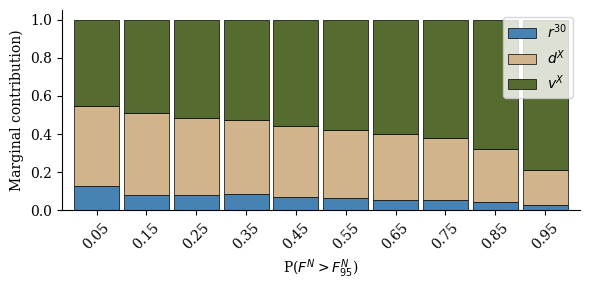

In [38]:
fig, ax = plt.subplots(figsize=(6,3))

df.plot.bar(stacked=True, color={r"$r^{{30}}$":"steelblue", r"$d^X$": "tan", r"$v^X$": "darkolivegreen"},
            width=0.9, rot=45, edgecolor="k", linewidth=0.5, ax=ax,
            ylabel="Marginal contribution)",
            xlabel=r"P($F^N>F^N_{95}$)");

ax.spines[['right', 'top']].set_visible(False)
fig.tight_layout()

fig.savefig(os.path.join(wd, "results", "figures", "marginal_contributions.png"), dpi=300, transparent=True, bbox_inches="tight")

In [250]:
wd

'hazGAN2/projects/poweruk_winter'